# Improved classification model

To improve a model, there are a few steps you can take:

- Add more layers: give the model more chances to fine tune the weights and parameters to better fit the data.
- Add more hidden units: increasing the number of units, also gives more chances for the model to learn patterns in the data.
- Train for longer: give more time for backpropagation to optimize the model's parameters.
- Changing activation functions: increase the non-linearity of the model.
- Changing the learning rate: a larger learning rate may increase the speed at which the model converges.

Most of the options above also increase the ability of the model to overfit, making it so that the model isn't actually learning, but instead just memorizing the data.

All of the ways presented to possibly improve the model are model centric, meaning they revolve around improving the results through the meddling of the model's architecture. This is not the only way of improving the results, there are other parts of the workflow that can be worked on instead.


## Setup


### Importing libraries


In [1]:
from pathlib import Path
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam

from helper_functions.helper_functions import (
    plot_predictions,
    plot_decision_boundary,
    accuracy_fn,
)

### Setting device


In [2]:
# Using gpu if available
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


### Defining functions


In [3]:
# Function to automatically run training loop
def training_loop(
    estimator: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    train_data: Tuple[torch.Tensor, torch.Tensor],
    validation_data: Tuple[torch.Tensor, torch.Tensor] | None = None,
    seed: int | None = None,
) -> Dict[str, List[float]]:

    if seed != None:
        torch.manual_seed(seed)

    X_train, y_train = train_data
    X_val, y_val = validation_data

    data_tracking = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    validation_print = ''

    for epoch in range(epochs):
        estimator.train()

        train_logits = estimator(X_train).squeeze()
        train_preds = torch.round(torch.sigmoid(train_logits))

        training_loss = loss_fn(train_logits, y_train)
        data_tracking['train_loss'].append(training_loss)

        training_acc = accuracy_fn(y_train, train_preds)
        data_tracking['train_acc'].append(training_acc)

        optimizer.zero_grad()
        training_loss.backward()

        optimizer.step()

        if validation_data != None:
            with torch.inference_mode():
                estimator.eval()
                val_logits = estimator(X_val).squeeze()
                val_preds = torch.round(torch.sigmoid(val_logits))

                validation_loss = loss_fn(val_logits, y_val)
                data_tracking['val_loss'].append(validation_loss)

                validation_acc = accuracy_fn(val_preds, y_val)
                data_tracking['val_acc'].append(validation_acc)

                validation_print = f'Validation loss: {validation_loss:.3f} | Validation acc: {validation_acc:.3f} |'

        if (epoch + 1) % 10 == 0:
            print(
                f'| Epoch: {epoch + 1}',
                f'\n| Training loss: {training_loss:.2f} | Training acc: {training_acc:.2f} |',
                validation_print,
            )
            print('-' * 90)

## 1- Making classification data

We're creating a "toy dataset", this is a dataset that is small enough to experiment, but sizeable enough to practice fundamentals.


In [4]:
# Making 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42,
)

In [5]:
# Creating Pandas DataFrame from data
circles = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'label': y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


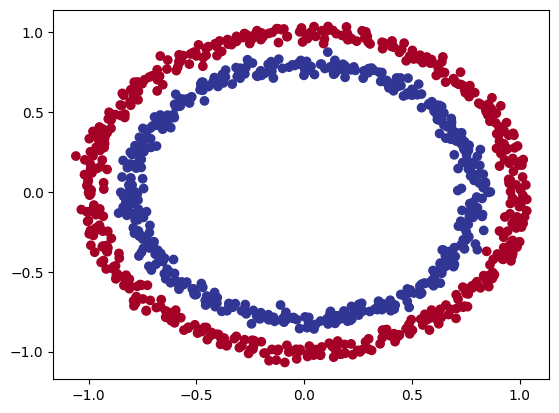

In [6]:
# Visualizing data
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

### 1.1- Setting data to tensors


In [7]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2- Creating improved model

Comparing to the initial model, this has a couple of improvements. The first is the addition of a whole other layer, the second is the increase in number of units per layer. Finally the addition of an activation function in between the first and second layer, and the second and third layer, introducing non-linearity into the model, allowing it to perform better on the non-linear data.


In [9]:
# Creating improved model
class CircleModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.relu(self.layer_1(x))
        z = self.relu(self.layer_2(z))
        z = self.layer_3(z)

        return z

In [10]:
# Instantiating model
model = CircleModel().to(device)

## 3- Picking a Loss Function and Optimizer


In [11]:
# Setting up the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setting up the optimizer
optimizer = Adam(
    params=model.parameters(),
    lr=0.1,
)

## 4- Training model


In [12]:
# Setting number of epochs
epochs = 60

# Training model
data_tracking = training_loop(
    estimator=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    train_data=(X_train, y_train),
    validation_data=(X_test, y_test),
    seed=42,
)

| Epoch: 10 
| Training loss: 0.59 | Training acc: 87.00 | Validation loss: 0.565 | Validation acc: 81.500 |
------------------------------------------------------------------------------------------
| Epoch: 20 
| Training loss: 0.30 | Training acc: 92.75 | Validation loss: 0.299 | Validation acc: 94.500 |
------------------------------------------------------------------------------------------
| Epoch: 30 
| Training loss: 0.13 | Training acc: 99.62 | Validation loss: 0.101 | Validation acc: 100.000 |
------------------------------------------------------------------------------------------
| Epoch: 40 
| Training loss: 0.06 | Training acc: 99.88 | Validation loss: 0.056 | Validation acc: 100.000 |
------------------------------------------------------------------------------------------
| Epoch: 50 
| Training loss: 0.03 | Training acc: 99.75 | Validation loss: 0.033 | Validation acc: 100.000 |
----------------------------------------------------------------------------------------

## 5- Making predictions and evaluate model


In [13]:
# Making predictions
with torch.inference_mode():
    y_preds = model(X_test)

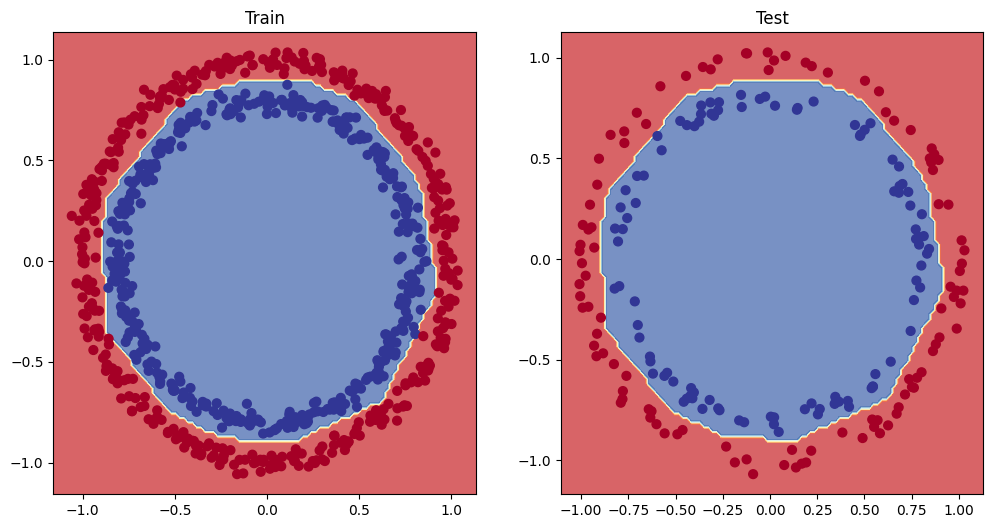

In [14]:
# Plot decision boundary of the model

# Train plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

# Test plot
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

## 7- Saving model


In [15]:
# Creating models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating model save path
MODEL_NAME = 'improved_classification.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/improved_classification.pth')

In [16]:
# Saving model state_dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [21]:
# Loading model
model = CircleModel().to(device)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [18]:
X_test.to(device)

tensor([[ 0.4495,  0.6662],
        [-0.3643,  0.7628],
        [ 0.7012,  0.3732],
        [-0.9055,  0.4988],
        [-0.6561,  0.6711],
        [ 0.7892,  0.0723],
        [ 0.0043, -0.7824],
        [ 0.2307,  0.7827],
        [ 0.6390, -0.5092],
        [-0.5447, -0.5643],
        [-0.9190, -0.4821],
        [ 0.1462,  0.7507],
        [ 0.6830,  0.4601],
        [ 0.9560, -0.1370],
        [-0.8440,  0.6172],
        [ 0.5319,  0.6748],
        [-0.6357, -0.4839],
        [-0.4110, -0.6910],
        [-0.4752,  0.6864],
        [-0.2770,  0.9921],
        [ 0.0822,  1.0096],
        [ 0.9071, -0.2448],
        [-0.7910,  0.2568],
        [-0.9145,  0.3697],
        [ 0.8626, -0.4564],
        [-0.2751,  0.7397],
        [-0.4570, -0.7083],
        [-0.7719,  0.6344],
        [-0.8837, -0.4678],
        [ 0.6134,  0.7296],
        [ 0.7750, -0.1064],
        [ 0.5449, -0.6336],
        [-0.1633, -0.8008],
        [ 0.9882, -0.1564],
        [-0.3577, -0.7438],
        [-0.9314, -0

In [ ]:
# Predicting and checking validity
model.eval()
with torch.inference_mode():
    loaded_lr_preds = model(X_test)

torch.equal(loaded_lr_preds, y_preds)

False